In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.point_clouds.raw_gan import RawGAN

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
n_pc_samples = 2048
do_training = True
first_time_running = True
load_model = False
seed = 42

class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
experiment_name = 'raw_pc_gan_'+ class_name +'_' + str(n_pc_samples) +  '_pts'

Give me the class type.
chair


In [18]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'

train_dir = osp.join(top_data_dir, 'OUT/models/nips/raw_gan/')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

KeyboardInterrupt: 

In [6]:
full_data = PointCloudDataSet(full_pclouds)

In [7]:
reset_tf_graph()
init_lr = 0.001
cgan = RawGAN(learning_rate=init_lr, n_output=[n_pc_samples, 3])

In [8]:
train_stats = []
batch_size = 50
while True:
    stat_i = cgan._single_epoch_train(full_data, batch_size, sigma=1)
    print stat_i
    train_stats.append(stat_i[0])

((0.96505033417984287, 1.6775965280003018), 30.939128160476685)
((1.1031282623608907, 1.2396634225492125), 30.62919592857361)
((1.0953249043888516, 1.3248892728929167), 30.635233163833618)
((1.1369770531301144, 1.3484964798997949), 31.06647300720215)
((1.1344818596486692, 1.4532239430480534), 30.705419063568115)
((0.96584648865240597, 1.7937082562181685), 30.928274869918823)
((0.90427127988250167, 2.1746445463763342), 31.02875304222107)
((0.87054780037314805, 2.2235594389615234), 31.161477088928223)
((0.96508768311253301, 2.1279720651882665), 30.970260858535767)
((0.83517226687184087, 2.370873197802791), 31.39445996284485)
((0.84324745491698938, 2.5220451299790985), 31.058861017227173)
((0.81523544280617322, 2.4846039975131), 31.0848491191864)
((0.80472070751366787, 2.7168565176151418), 31.44876003265381)
((0.85541575286123483, 2.5726599331255313), 32.46928882598877)
((0.89584589997927344, 2.2889081034395429), 31.31483292579651)
((0.8962960380095023, 2.4016333880247891), 31.32503294944

KeyboardInterrupt: 

In [14]:
n_gen_sampes = 1000
gen_samples = np.zeros((n_gen_sampes, n_pc_samples, 3))
for i in xrange(n_gen_sampes):
    pc_gen = cgan.generate(cgan.generator_noise_distribution(1, 128, sigma=1))[0][0]
    gen_samples[i,:,:] = pc_gen

In [15]:
np.savez('/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/raw_gan_panos_v1', gen_samples)


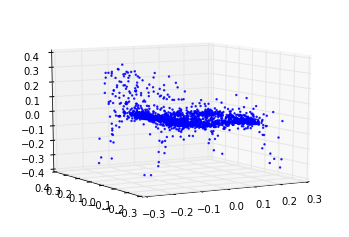

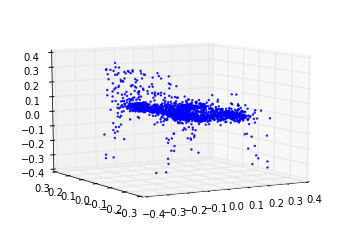

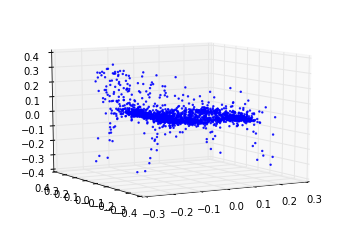

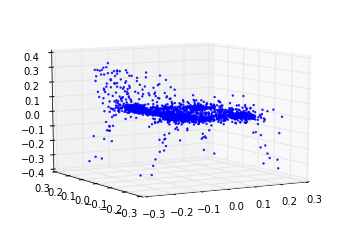

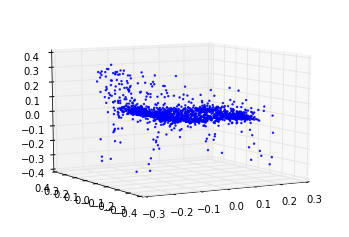

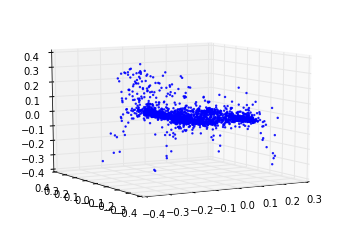

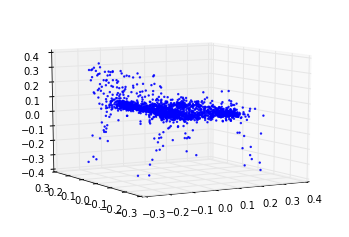

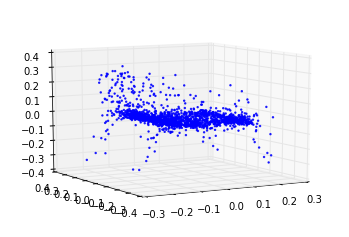

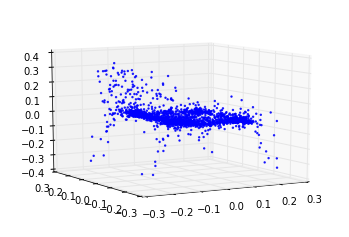

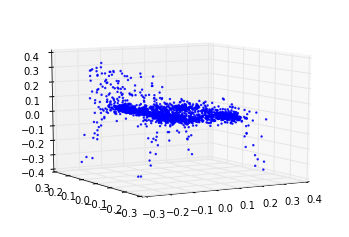

In [16]:
for pc in gen_samples[:10]:
    Point_Cloud(pc).plot()

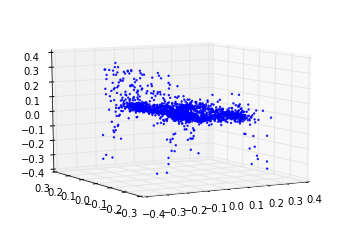

In [13]:
pc_gen = cgan.generate(cgan.generator_noise_distribution(1, 128, sigma=1))[0]
pc_gen = Point_Cloud(points=pc_gen[0])
pc_gen.plot();



# z = cgan.generator_noise_distribution(5, cgan.noise_dim, sigma=1)
# print z.shape
# rl = cgan.real_prob
# rf = cgan.synthetic_prob
# p = cgan.generator_out
# res = cgan.sess.run([rf], feed_dict={cgan.noise:z, cgan.real_pc: full_data.next_batch(5)[0]})
# print res
# Point_Cloud(res[0][0]).plot()